# XAI anlaysis for SVM

# Importing modules

In [ ]:
!pip install lime
!pip install shap 
!pip install aix360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import re

from pandas.io.formats.style_render import DataFrame
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from math import ceil
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import *
import pickle

import lime
import lime.lime_tabular
import shap

from aix360.metrics import faithfulness_metric, monotonicity_metric

# Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/Shareddrives/DM_Project/dataset/users_clustering.csv /content/
!cp /content/drive/Shareddrives/DM_Project/dataset/users_extended_clean.csv /content/
!cp /content/drive/Shareddrives/DM_Project/models/svm.sav /content/

In [ ]:
users = pd.read_csv("users_clustering.csv")

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11508 non-null  int64  
 1   name                    11508 non-null  object 
 2   lang                    11508 non-null  object 
 3   bot                     11508 non-null  int64  
 4   created_at              11508 non-null  object 
 5   statuses_count          11508 non-null  int64  
 6   reply_count_total       11508 non-null  float64
 7   favorite_count_total    11508 non-null  int64  
 8   num_hashtags_total      11508 non-null  int64  
 9   retweet_count_avg       11508 non-null  float64
 10  reply_count_avg         11508 non-null  float64
 11  favorite_count_avg      11508 non-null  float64
 12  num_hashtags_avg        11508 non-null  float64
 13  num_urls_avg            11508 non-null  float64
 14  num_mentions_avg        11508 non-null

# Build the dataset

# Apply log transformation to skewed distribution

In [ ]:
selected = users.columns.tolist()[5:]

non_skewed_dists = [
  "avg_spc_len",
  "avg_len",
  "num_mentions_entropy",
  "num_hashtags_entropy",
  "favorite_count_entropy",
  "retweet_count_entropy",
  "num_mentions_std",
  "num_urls_std",
  "num_hashtags_std",
  "num_mentions_avg",
  "num_urls_avg"
]

for col in selected:
  if col not in non_skewed_dists:
    print(col)
    users.loc[:, col] = users[col].apply(lambda x: np.log10(x+1))

statuses_count
reply_count_total
favorite_count_total
num_hashtags_total
retweet_count_avg
reply_count_avg
favorite_count_avg
num_hashtags_avg
retweet_count_std
reply_count_std
favorite_count_std
reply_count_entropy
retweet_count_per_day
reply_count_per_day
favorite_count_per_day
num_hashtags_per_day


## Train-test sets split

In [ ]:
users.drop(columns=['name', 'lang', 'created_at', "id"], axis=1, inplace=True)
# users = users[classification_cols+["bot"]]

In [ ]:
label = users.pop('bot')
train_set, test_set, train_label, test_label = train_test_split(users, label, stratify =label, test_size=0.20, random_state=42)
train_set

statuses_count  reply_count_total  favorite_count_total  \
645         3.490099           0.903090              3.048442   
684         1.724276           0.000000              1.653213   
4300        1.826075           0.602060              2.856124   
2899        1.462398           0.000000              0.698970   
9035        1.748188           0.000000              1.278754   
...              ...                ...                   ...   
5337        2.110590           0.602060              2.848805   
2410        1.707570           0.477121              3.622214   
8568        2.578639           0.000000              1.982271   
3330        1.431364           0.000000              0.698970   
3223        1.748188           0.000000              2.161368   

      num_hashtags_total  retweet_count_avg  reply_count_avg  \
645             2.717671           2.659602         0.001007   
684             0.954243           1.528531         0.000000   
4300            2.247973           2.311984         0.000983   
2899            0.477121           2.488697         0.000000   
9035            1.041393           2.141763         0.000000   
...                  ...                ...              ...   
5337            2.267172           2.685116         0.000938   
2410            2.287802           2.630155         0.000664   
8568            1.633468           2.430860         0.000000   
3330            0.477121           3.017019         0.000000   
3223            1.079181           1.792511         0.000000   

      favorite_count_avg  num_hashtags_avg  num_urls_avg  num_mentions_avg  \
645             0.136873          0.069225      0.139967          0.517745   
684             0.158362          0.033424      0.120000          0.460000   
4300            0.187955          0.054203      0.151057          0.503021   
2899            0.056116          0.028964      0.172414          0.482759   
9035            0.122960          0.072551      0.200000          0.600000   
...                  ...               ...           ...               ...   
5337            0.178485          0.054100      0.164384          0.498919   
2410            0.623771          0.059816      0.161438          0.525631   
8568            0.128869          0.061727      0.156364          0.490909   
3330            0.056116          0.028964      0.206897          0.620690   
3223            0.348455          0.039024      0.085470          0.564103   

      ...  reply_count_entropy  favorite_count_entropy  num_hashtags_entropy  \
645   ...             0.010157                0.980957              0.657790   
684   ...             0.000000                0.857269              0.382543   
4300  ...             0.009949                1.132299              0.557380   
2899  ...             0.000000                0.574828              0.216397   
9035  ...             0.000000                0.970062              0.716352   
...   ...                  ...                     ...                   ...   
5337  ...             0.009564                1.076976              0.563522   
2410  ...             0.007114                1.092085              0.589942   
8568  ...             0.000000                0.923833              0.596771   
3330  ...             0.000000                0.574828              0.362051   
3223  ...             0.000000                1.190364              0.450029   

      num_mentions_entropy  retweet_count_per_day  reply_count_per_day  \
645               1.372384               4.001260             0.021642   
684               1.200562               0.934662             0.000000   
4300              1.328115               2.380483             0.001151   
2899              1.247424               0.980241             0.000000   
9035              1.494333               0.917135             0.000000   
...                    ...                    ...                  ...   
5337              1.332631              

In [ ]:
print(train_set.shape, train_label.shape)
print(test_set.shape, test_label.shape)

(9206, 27) (9206,)
(2302, 27) (2302,)


# Standardize the data

In [ ]:
unnorm_train_set = train_set.copy()
unnorm_test_set = test_set.copy()
norm_train_set = train_set.copy()
norm_test_set = test_set.copy()

method = "standard"

if method == "minmax":
  scaler = MinMaxScaler()
elif method == "standard":
  scaler = StandardScaler()

norm_train_set.loc[:, :] = scaler.fit_transform(norm_train_set.loc[:, :])
norm_test_set.loc[:, :] = scaler.transform(norm_test_set.loc[:, :])
# train_label = scaler.fit_transform(train_label)
#test_label = scaler.fit_transform(test_label)


# Fit the SVM model

In [ ]:
train_set = norm_train_set.copy()
test_set = norm_test_set.copy()

svm = SVC(kernel="rbf", C = 100, gamma=0.01, probability=True, random_state=42)
svm.fit(train_set.values, train_label.values)

SVC(C=100, gamma=0.01, probability=True, random_state=42)

# LIME

In [ ]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(train_set.values,
                                                        feature_names=train_set.columns.tolist(),
                                                        class_names=["real", "bot"],
                                                        discretize_continuous=True, random_state=10)

In [ ]:
exp = lime_explainer.explain_instance(train_set.values[0], svm.predict_proba, top_labels=0)
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
exp = lime_explainer.explain_instance(train_set.values[0], svm.predict_proba, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
exp = lime_explainer.explain_instance(train_set.values[1], svm.predict_proba, top_labels=0)
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
exp = lime_explainer.explain_instance(train_set.values[1], svm.predict_proba, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

# Lime evaluation

In [ ]:
exp.local_exp

{1: [(3, -0.34263807700967575),
  (0, 0.1616266287623545),
  (21, -0.09286515900723402),
  (8, 0.08135497564322566),
  (2, -0.07533249166341494),
  (7, 0.06809361968624124),
  (1, 0.06424546325860997),
  (18, 0.05486914837734383),
  (23, 0.052883598398179764),
  (19, 0.049510172366174214)]}

In [ ]:
ncases = 100
x = train_set.values[0]
fait = np.zeros(ncases)
base = np.zeros(x.shape[0])

mono = []
with tqdm(total=len(range(ncases))) as pbar:
  for i in range(ncases):
    predicted_class = svm.predict(train_set.values[i].reshape(1,-1))[0]
    exp = lime_explainer.explain_instance(train_set.values[i], svm.predict_proba, labels=(predicted_class, ))
    le = exp.local_exp[predicted_class]
    m = exp.as_map()
    
    x = train_set.values[i]
    coefs = np.zeros(x.shape[0])
    
    for v in le:
      coefs[v[0]] = v[1]
    fait[i] = faithfulness_metric(svm, train_set.values[i], coefs, base)
    monotone = monotonicity_metric(svm,  x, coefs, base)
    mono.append(monotone)
    pbar.update(1)


mono = np.array(mono)
print("\nFaithfulness metric mean: ", np.mean(fait))
print("Faithfulness metric standard deviation:", np.std(fait))
print(f"Monotinicity: {mono.sum()}/{len(mono)}")

100%|██████████| 100/100 [20:38<00:00, 12.38s/it]


Faithfulness metric mean:  0.47490180991729397
Faithfulness metric standard deviation: 0.3003542782533542
Monotinicity: 0/100


# SHAP

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_set = norm_train_set.copy()
test_set = norm_test_set.copy()

svm = SVC(kernel="rbf", C = 100, gamma=0.01, probability=True, random_state=42)
svm.fit(train_set.values, train_label.values)

SVC(C=100, gamma=0.01, probability=True, random_state=42)

In [ ]:
shap_test_set = test_set[0:50]

svm_explainer = shap.KernelExplainer(svm.predict, shap_test_set.values)
shap_values = svm_explainer.shap_values(shap_test_set.values)

  0%|          | 0/50 [00:00<?, ?it/s]

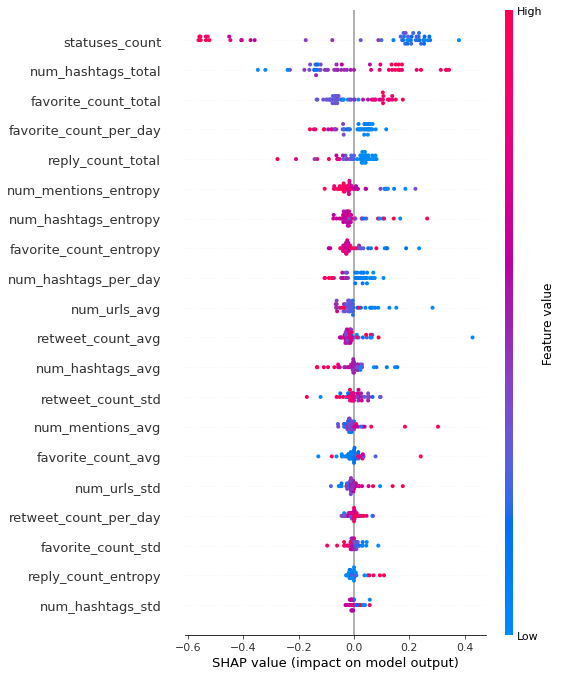

In [ ]:
shap.summary_plot(shap_values, shap_test_set)

In [ ]:
shap.initjs()
shap.force_plot(svm_explainer.expected_value, shap_values, shap_test_set)

In [ ]:
shap.initjs()
shap.force_plot(svm_explainer.expected_value, shap_values[10,:], test_set.iloc[10,:])

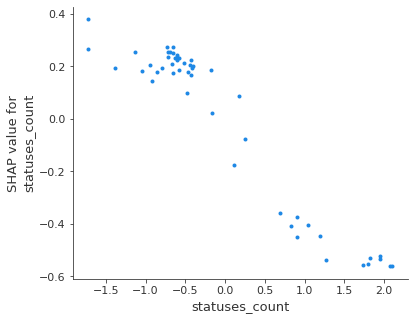

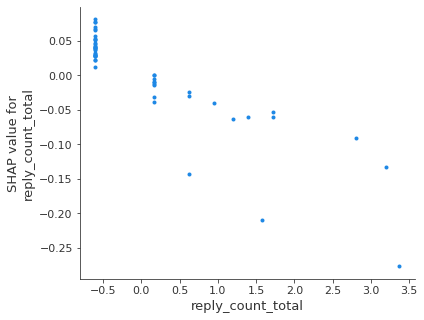

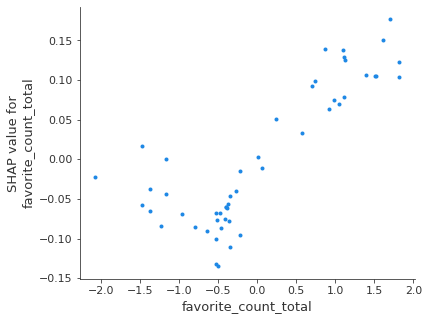

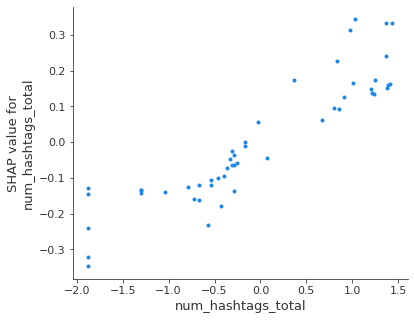

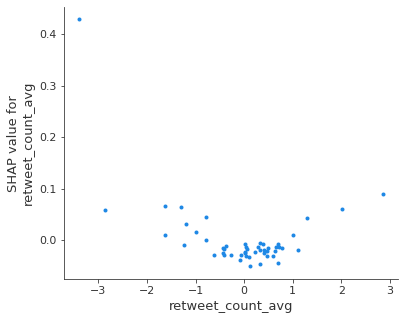

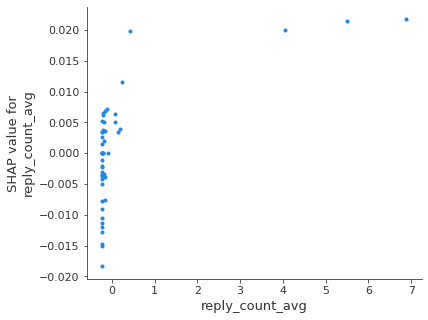

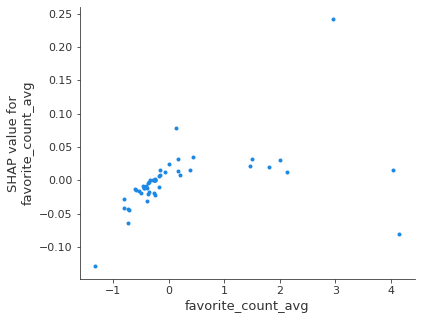

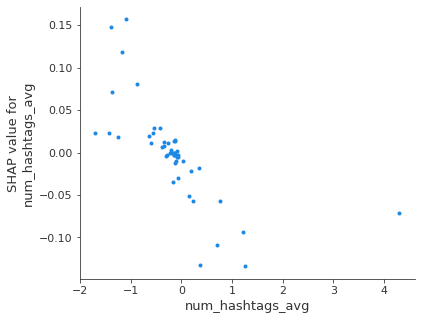

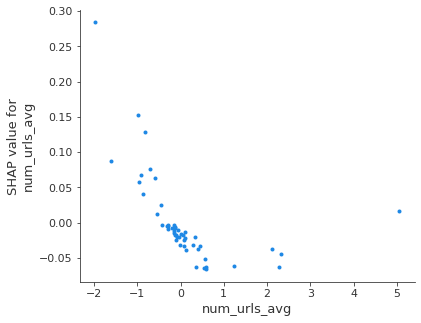

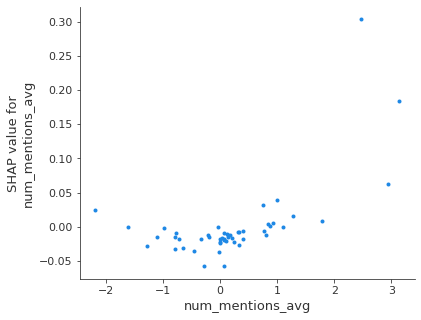

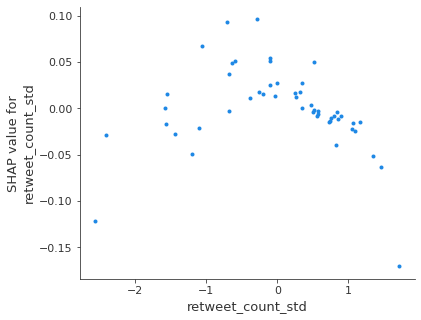

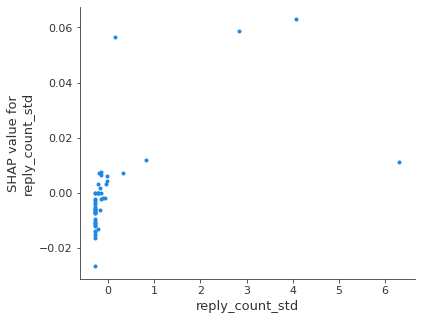

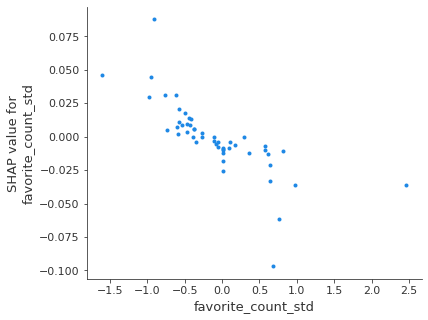

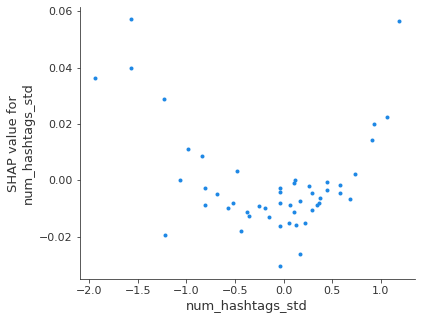

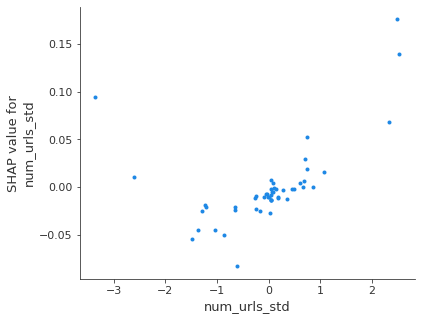

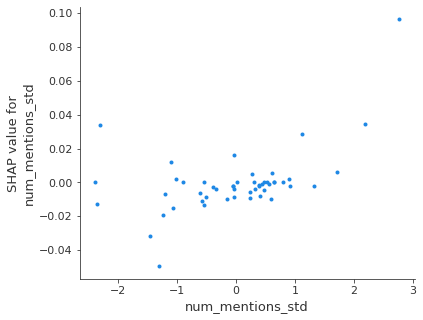

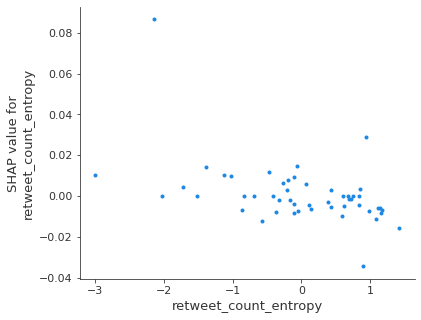

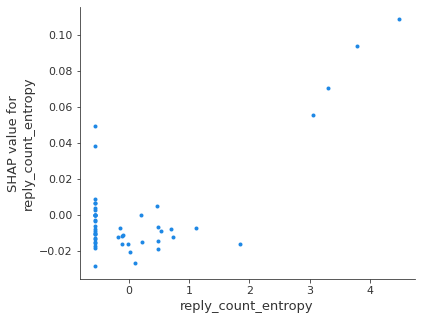

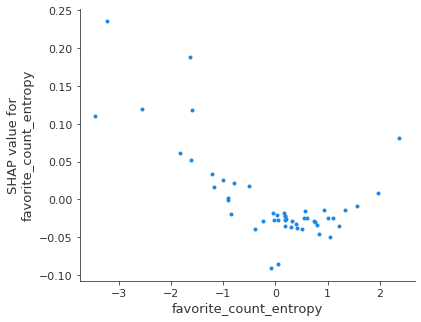

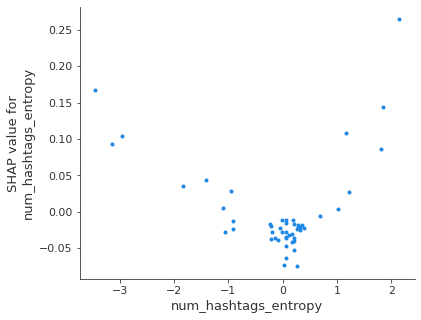

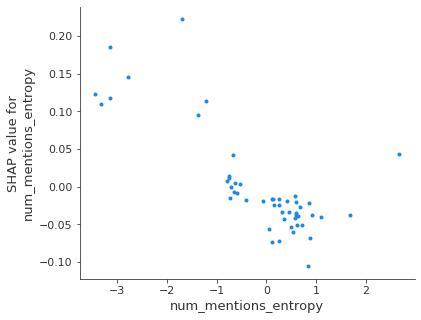

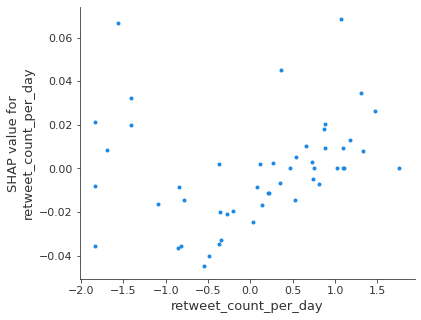

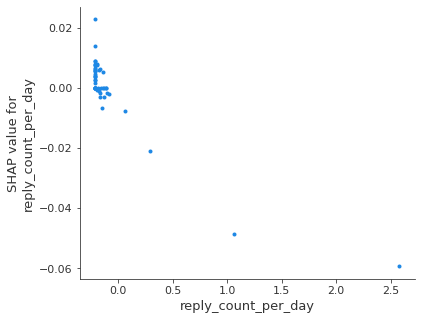

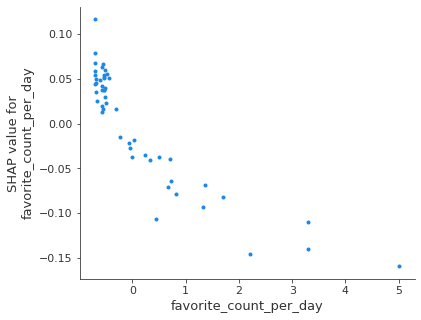

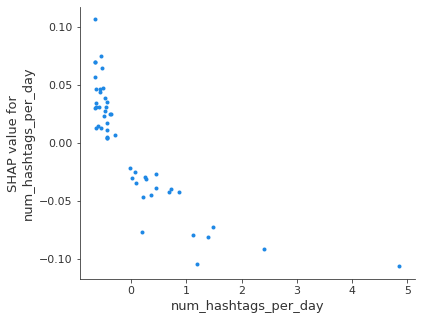

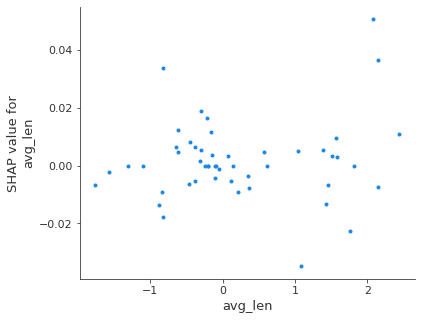

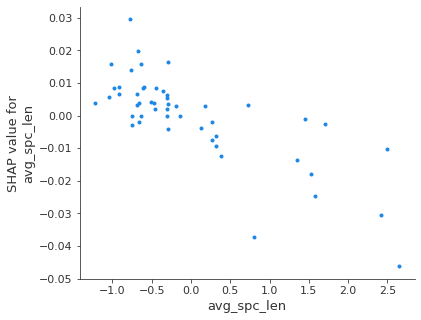

In [ ]:
for col in train_set.columns:
  shap.dependence_plot(col, shap_values, shap_test_set, interaction_index=None)

# SHAP Evaluation

In [ ]:
ncases = 100
x = train_set.values[0]
fait = np.zeros(ncases)
base = np.zeros(x.shape[0])
mono = []

with tqdm(total=len(range(ncases))) as pbar:
  for i in range(ncases):
    predicted_class = svm.predict(test_set.values[i].reshape(1,-1))[0]
    fait[i] = faithfulness_metric(svm, test_set.values[i], shap_values[predicted_class], base)
    monotone = monotonicity_metric(svm, x, shap_values[predicted_class], base)
    mono.append(monotone)
    pbar.update(1)

mono = np.array(mono)
print("\nFaithfulness metric mean: ", np.mean(fait))
print("Faithfulness metric standard deviation:", np.std(fait))
print(f"Monotinicity: {mono.sum()}/{len(mono)}")

100%|██████████| 100/100 [00:01<00:00, 63.60it/s]


Faithfulness metric mean:  0.17722591779962577
Faithfulness metric standard deviation: 0.37451415341178984
Monotinicity: 0/100
